In [ ]:
#importamos la función random
import numpy as np

#las partes necesarias para correr en un circuito cuantico
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from math import pi as π
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt

In [ ]:
Service = QiskitRuntimeService(channel="ibm_quantum",token="YourTokenHere")

In [ ]:
# definimos el backend
backend_osk = Service.backend("ibm_sherbrooke") #usaremos este procesador cuántico
sampler_osk = SamplerV2(backend_osk)

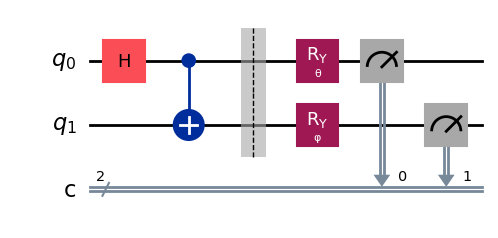

In [ ]:
#un circuito parametrizado es más complicado:
θ=Parameter('θ')
φ=Parameter('φ')

qc1 = QuantumCircuit(2, 2)
qc1.h(0)
qc1.cx(0, 1)
qc1.barrier()

qc1.ry(θ, 0)
qc1.ry(φ, 1)

qc1.measure(0, 0)
qc1.measure(1, 1)

qcCompilado = transpile(qc1, backend=backend_osk,initial_layout=[79, 80])
qc1.draw('mpl')

In [ ]:
def get_analytic_probs(theta, phi):
    """
    Calcula las probabilidades teóricas del circuito CHSH
    luego de aplicar RY(theta) y RY(phi) al estado de Bell.
    """
    ctheta = np.cos(theta / 2)
    stheta = np.sin(theta / 2)
    cphi = np.cos(phi / 2)
    sphi = np.sin(phi / 2)
    
    # Estado final = (I ⊗ RY(phi)) (RY(theta) ⊗ I) (|00> + |11>) / sqrt(2)
    # Calculamos amplitudes de cada base
    amp_00 = (ctheta * cphi + stheta * sphi) / np.sqrt(2)
    amp_01 = (ctheta * (-sphi) + stheta * cphi) / np.sqrt(2)
    amp_10 = (-stheta * cphi + ctheta * sphi) / np.sqrt(2)
    amp_11 = (-stheta * (-sphi) + ctheta * cphi) / np.sqrt(2)

    # Probabilidades
    probs = {
        '00': np.abs(amp_00)**2,
        '01': np.abs(amp_01)**2,
        '10': np.abs(amp_10)**2,
        '11': np.abs(amp_11)**2,
    }
    return probs
def plot_comparison(qpu_probs, analytic_probs, title):
    labels = ['00', '01', '10', '11']
    x = np.arange(len(labels))
    width = 0.35

    qpu_vals = [qpu_probs.get(label, 0) for label in labels]
    ana_vals = [analytic_probs.get(label, 0) for label in labels]

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, qpu_vals, width, label='QPU')
    bars2 = ax.bar(x + width/2, ana_vals, width, label='Analytical')

    # Anotar valores
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

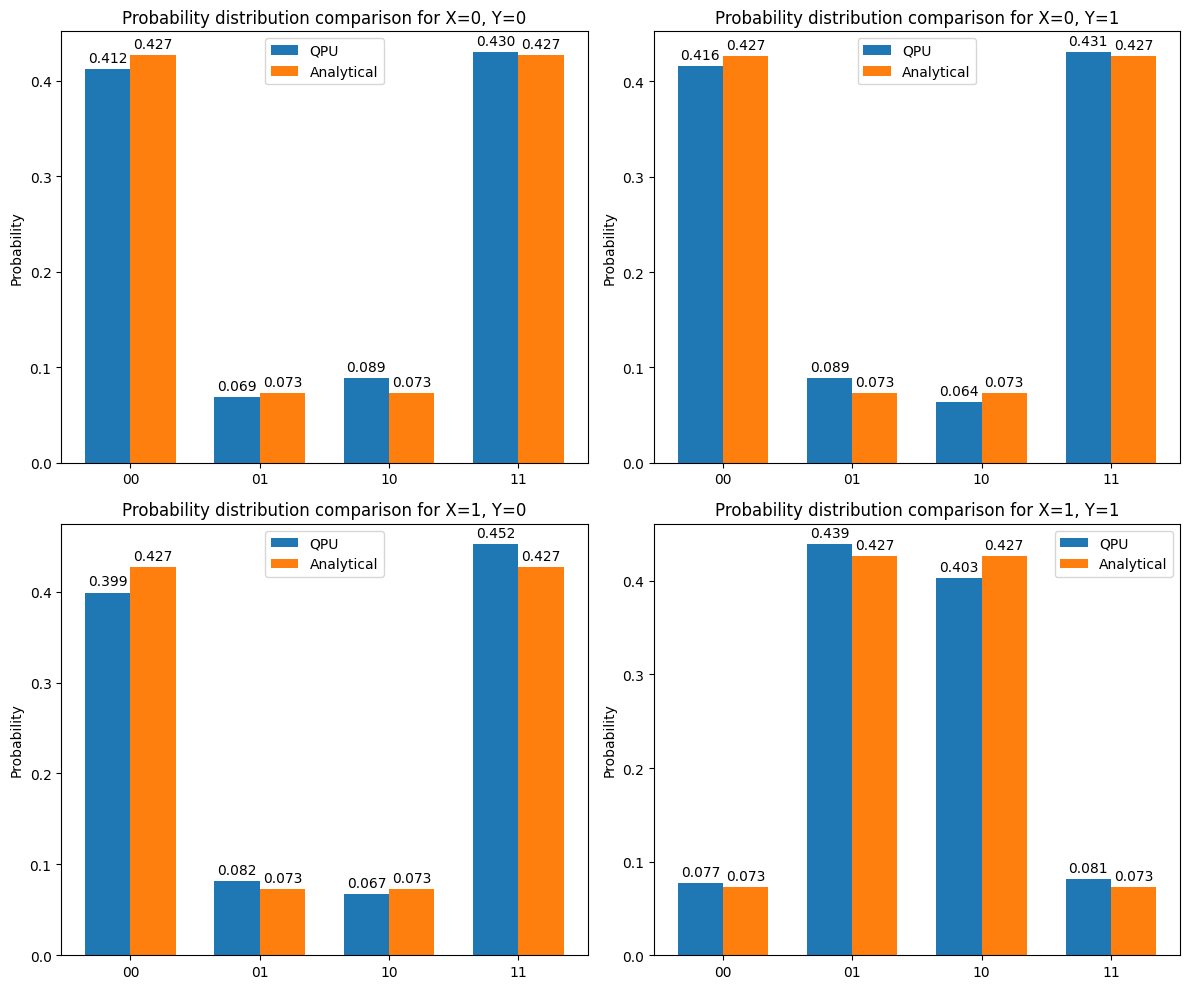

In [ ]:
# Definir los ángulos y títulos para cada caso
casos = [
    {"theta": 0, "phi": -π/4, "X": 0, "Y": 0, "titulo": "X=0, Y=0"},
    {"theta": 0, "phi": π/4,  "X": 0, "Y": 1, "titulo": "X=0, Y=1"},
    {"theta": -π/2, "phi": -π/4, "X": 1, "Y": 0, "titulo": "X=1, Y=0"},
    {"theta": -π/2, "phi": π/4,  "X": 1, "Y": 1, "titulo": "X=1, Y=1"},
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for idx, caso in enumerate(casos):
    # Obtener resultados del QPU
    job_osk = sampler_osk.run([(qcCompilado, [caso["theta"],caso["phi"]], 1000)])
    result_osk = job_osk.result()
    counts_qc1_osk = result_osk[0].data.c.get_counts()
    total_shots = sum(counts_qc1_osk.values())
    qpu_probs = {k: v / total_shots for k, v in counts_qc1_osk.items()}

    # Probabilidades analíticas
    analytic_probs = get_analytic_probs(caso["theta"], caso["phi"])

    # Preparar datos para graficar
    labels = ['00', '01', '10', '11']
    qpu_vals = [qpu_probs.get(label, 0) for label in labels]
    ana_vals = [analytic_probs.get(label, 0) for label in labels]
    x = np.arange(len(labels))
    width = 0.35

    # Graficar en el subplot correspondiente
    ax = axs[idx]
    bars1 = ax.bar(x - width/2, qpu_vals, width, label='QPU')
    bars2 = ax.bar(x + width/2, ana_vals, width, label='Analytical')

    # Anotar valores
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_ylabel('Probability')
    ax.set_title(f'Probability distribution comparison for {caso["titulo"]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

num_corridas = 100
num_shots = 1000
labels = ['00', '01', '10', '11']

for caso in casos:
    print(f"\nCaso: {caso['titulo']}")
    # Prepara la lista de ángulos para cada corrida
    Angulos = [[caso["theta"], caso["phi"]] for _ in range(num_corridas)]
    # Prepara la lista de corridas
    Crc = [(qcCompilado, Angulos[i], num_shots) for i in range(num_corridas)]
    # Ejecuta todas las corridas en un solo job
    job = sampler_osk.run(Crc)
    result = job.result()
    print(f"¡Corridas ejecutadas! Job ID: {job.job_id()}")
    
    # Procesa los resultados
    resultados = {label: [] for label in labels}
    for i in range(num_corridas):
        counts = result[i].data.c.get_counts()
        total = sum(counts.values())
        for label in labels:
            prob = counts.get(label, 0) / total
            resultados[label].append(prob)
    
    # Calcular estadísticas y guardar para Excel
    analytic = get_analytic_probs(caso["theta"], caso["phi"])
    resultados_excel = []
    print("Estado | Media   | Desv.Std | Desv.Sist")
    for label in labels:
        datos = np.array(resultados[label])
        media = np.mean(datos)
        desv_std = np.std(datos)
        desv_sist = media - analytic[label]
        print(f"{label:>5} | {media:.4f} | {desv_std:.4f} | {desv_sist:.4f}")
        resultados_excel.append({
            "Caso": caso["titulo"],
            "Estado": label,
            "Media": media,
            "Desviacion_Estandar": desv_std,
            "Desviacion_Sistematica": desv_sist,
            "Analitico": analytic[label]
        })
    # Guardar en Excel por cada caso (puedes cambiar para guardar todo junto si prefieres)
    # Guardar los datos crudos de cada corrida
    datos_crudos = []
    for i in range(num_corridas):
        counts = result[i].data.c.get_counts()
        total = sum(counts.values())
        fila = {"Corrida": i+1}
        for label in labels:
            fila[label] = counts.get(label, 0) / total
        datos_crudos.append(fila)
    
    # Guardar en Excel los datos crudos
    df_crudos = pd.DataFrame(datos_crudos)
    df_crudos.to_excel(f"datos_crudos_{caso['titulo'].replace('=', '').replace(',', '').replace(' ', '')}.xlsx", index=False)
    print(f"¡Datos crudos guardados en datos_crudos_{caso['titulo']}.xlsx!")
    df = pd.DataFrame(resultados_excel)
    df.to_excel(f"estadisticas_{caso['titulo'].replace('=', '').replace(',', '').replace(' ', '')}.xlsx", index=False)
    print(f"¡Resultados guardados en estadisticas_{caso['titulo']}.xlsx!")


Caso: X=0, Y=1
¡Corridas ejecutadas! Job ID: d0yd6tbvx7bg0082dk30
Estado | Media   | Desv.Std | Desv.Sist
   00 | 0.4009 | 0.0175 | -0.0259
   01 | 0.0873 | 0.0085 | 0.0141
   10 | 0.0955 | 0.0098 | 0.0223
   11 | 0.4162 | 0.0153 | -0.0106
¡Datos crudos guardados en datos_crudos_X=0, Y=1.xlsx!
¡Resultados guardados en estadisticas_X=0, Y=1.xlsx!

Caso: X=1, Y=0
¡Corridas ejecutadas! Job ID: d0yd74m7qc70008sdbvg
Estado | Media   | Desv.Std | Desv.Sist
   00 | 0.4189 | 0.0153 | -0.0079
   01 | 0.0902 | 0.0092 | 0.0170
   10 | 0.0950 | 0.0087 | 0.0218
   11 | 0.3959 | 0.0152 | -0.0309
¡Datos crudos guardados en datos_crudos_X=1, Y=0.xlsx!
¡Resultados guardados en estadisticas_X=1, Y=0.xlsx!

Caso: X=1, Y=1
¡Corridas ejecutadas! Job ID: d0yd7ex1wej00089wyeg
Estado | Media   | Desv.Std | Desv.Sist
   00 | 0.0708 | 0.0077 | -0.0024
   01 | 0.4185 | 0.0161 | -0.0083
   10 | 0.4397 | 0.0172 | 0.0129
   11 | 0.0710 | 0.0092 | -0.0022
¡Datos crudos guardados en datos_crudos_X=1, Y=1.xlsx!
¡Resu